<a href="https://colab.research.google.com/github/jeniferwerthman/AdvAILSTM/blob/main/Copy_of_LSTMStock_Take2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [208]:
!pip install -q yfinance

In [209]:
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader.data import DataReader

import yfinance as yf

import matplotlib.pyplot as mplot
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates

import numpy as np 

from datetime import datetime as dt
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [210]:
#Import Data 
stockTypes = ['TSLA','AAPL', 'GOOG', 'MSFT', 'AMZN', 'DELL']

#Import from API
end = dt.now()
start = dt(end.year - 4, end.month, end.day)
for stockDf in stockTypes:
    globals()[stockDf] = yf.download(stockDf, start, end)

number_of_days = end - start
us_bd = np.busdaycalendar
datelist_past = pd.date_range(start, end, freq='C').tolist()    

#Add Name
stocks = [TSLA, AAPL, GOOG, MSFT, AMZN, DELL]
company_name = ["TESLA", "APPLE", "GOOGLE", "MICROSOFT", "AMAZON", "DELL"]

#Make date part of dataset
for stock in stocks:
  stock["Date"] = stock.index
  stock = stock[["Date", "Open", "High", 
              "Low", "Close", "Adj Close", "Volume"]]
  stock.reset_index(drop=True, inplace=True)
  print(stock.head(2))

for stock, name in zip(stocks, company_name):
    stock["company_name"] = name

#Additional Columns
for stock in stocks:
    stock['openChange'] = stock.Open.pct_change()
    stock['closeChange'] = stock.Close.pct_change()
    stock['volumeChange'] = stock.Volume.pct_change() 
    stock['weekday_num'] = pd.DatetimeIndex(stock['Date']).weekday
    stock['month'] = pd.DatetimeIndex(stock['Date']).month
    stock['day'] = pd.DatetimeIndex(stock['Date']).day
    stock['year'] = pd.DatetimeIndex(stock['Date']).year
    stock['display'] = stock["month"].map(str)+ "-" + stock["year"].map(str)

# Select features (columns) to be involved intro training and predictions
cols = list(stocks[1])[0:1]
#cols.pop(1) #Delete middle column

print('Training set shape == {}'.format(stocks[1].shape))
print('Featured selected: {}'.format(cols))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
        Date       Open       High        Low      Close  Adj Close    Volume
0 2018-05-04  56.599998  59.372002  55.903999  58.818001  58.818001  42847000
1 2018-05-07  59.500000  61.192001  59.034000  60.554001  60.554001  43391000
        Date       Open     High      Low      Close  Adj Close     Volume
0 2018-05-04  44.562500  46.0625  44.5425  45.957500  44.077660  224805200
1 2018-05-07  46.294998  46.9175  46.1875  46.290001  44.396553  169805600
        Date         Open         High          Low        Close    Adj Close  \
0 2018-05-04  1016.900024  1048.510010  1016.9

In [211]:
DELL.head()

,Open,High,Low,Close,Adj Close,Volume,Date,company_name,openChange,closeChange,volumeChange,weekday_num,month,day,year,display
Date,,,,,,,,,,,,,,,,
2018-05-04,19.889214,20.641338,19.807825,20.472952,20.330540,2996327,2018-05-04,DELL,NaN,NaN,NaN,4,5,4,2018,5-2018
2018-05-07,20.486984,20.795692,20.293341,20.343857,20.202341,2057770,2018-05-07,DELL,0.030055,-0.006306,-0.313236,0,5,7,2018,5-2018
2018-05-08,20.352276,20.352276,19.936922,20.209146,20.068569,5340225,2018-05-08,DELL,-0.006575,-0.006622,1.595152,1,5,8,2018,5-2018
2018-05-09,20.284922,20.669401,20.225985,20.408403,20.266439,5428237,2018-05-09,DELL,-0.003309,0.009860,0.016481,2,5,9,2018,5-2018
2018-05-10,20.461725,21.163336,20.447695,20.961271,20.815462,4681738,2018-05-10,DELL,0.008716,0.027090,-0.137521,3,5,10,2018,5-2018


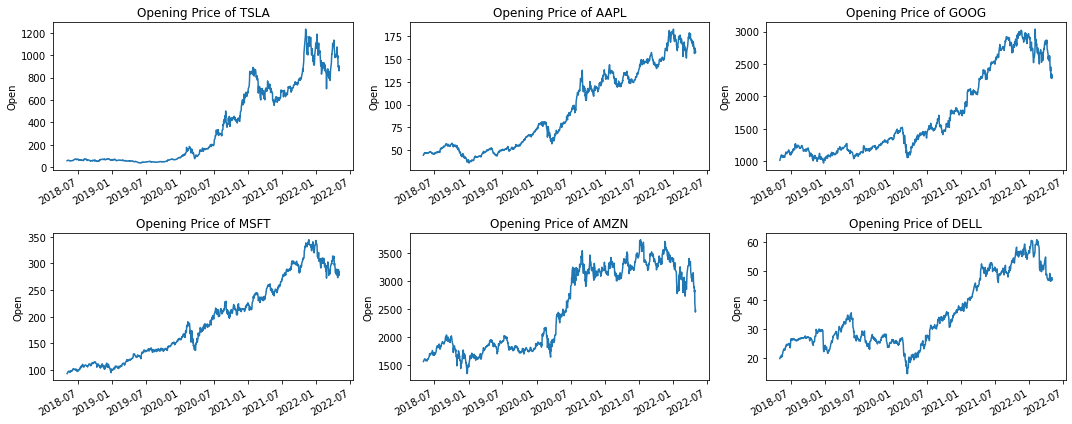

In [212]:
#Opening Graph
mplot.figure(figsize=(15, 6))
mplot.subplots_adjust(top=1.25, bottom=1)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['Open'].plot()
    mplot.ylabel('Open')
    mplot.xlabel(None)
    mplot.title(f"Opening Price of {stockTypes[i - 1]}")
    
mplot.tight_layout()

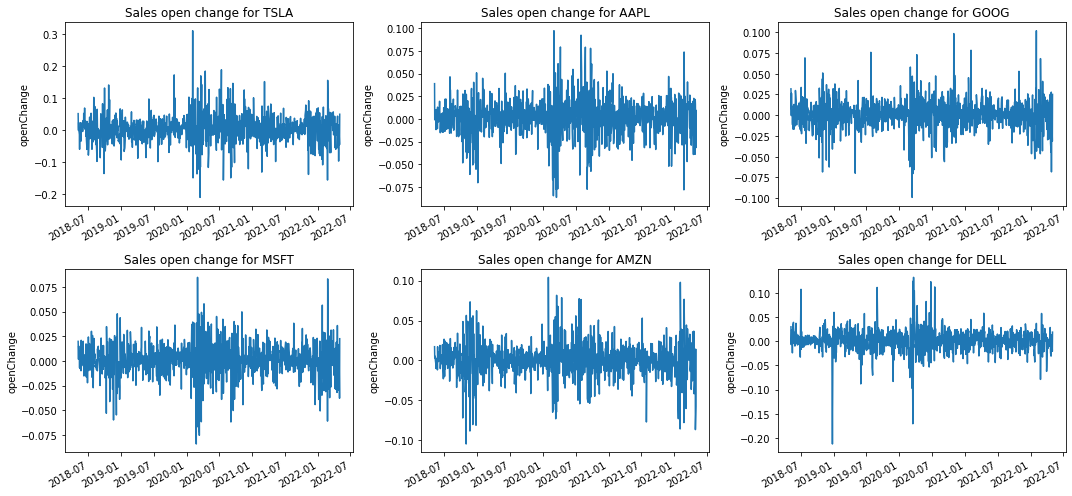

In [213]:
#Change Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['openChange'].plot()
    mplot.ylabel('openChange')
    mplot.xlabel(None)
    mplot.title(f"Sales open change for {stockTypes[i - 1]}")
    
mplot.tight_layout()

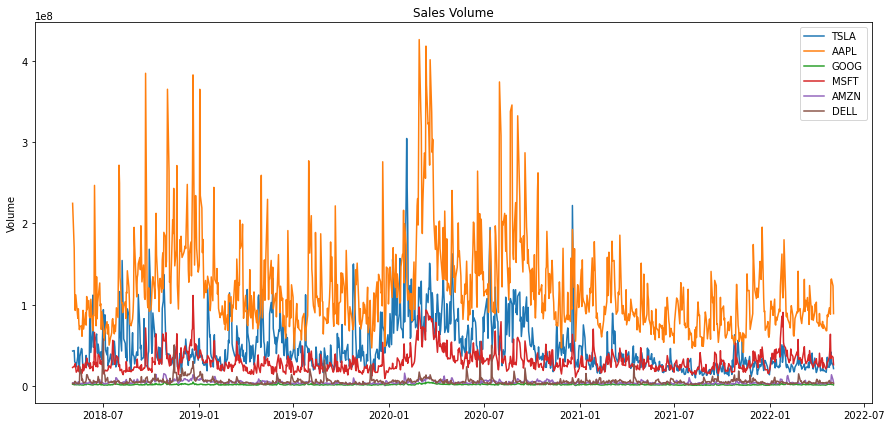

In [214]:
mplot.figure(figsize=(15, 7))
mplot.title(f"Sales Volume")
for i, stock in enumerate(stocks, 1):
  mplot.plot(stock['Volume'], label = stockTypes[i - 1]) 
  
mplot.ylabel('Volume')
mplot.xlabel(None)
mplot.legend()
mplot.show()  

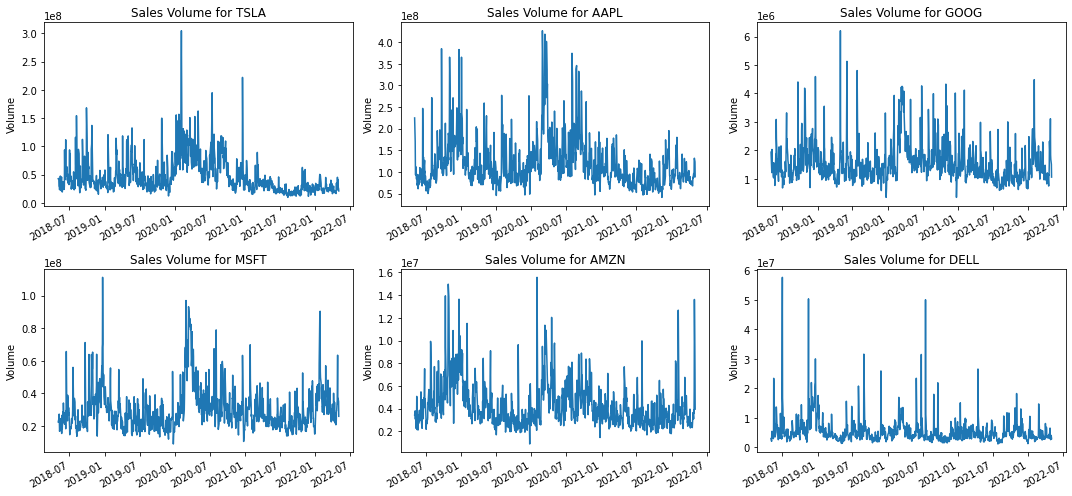

In [215]:
#Volume Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['Volume'].plot()
    mplot.ylabel('Volume')
    mplot.xlabel(None)
    mplot.title(f"Sales Volume for {stockTypes[i - 1]}")
    
mplot.tight_layout()

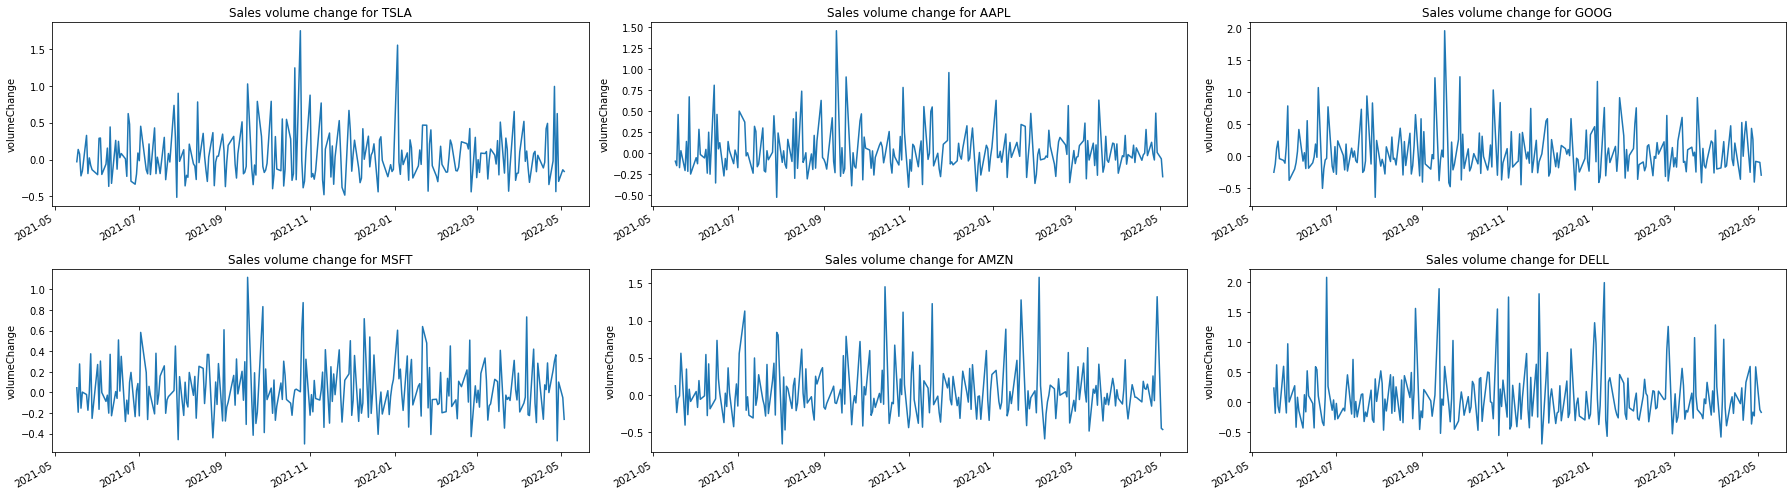

In [216]:
#Volume Change Graphs
mplot.figure(figsize=(25, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['volumeChange'][-244:].plot()
    mplot.ylabel('volumeChange')
    mplot.xlabel(None)
    mplot.title(f"Sales volume change for {stockTypes[i - 1]}")
    
mplot.tight_layout()

In [240]:
stocks[1]

,Open,High,Low,Close,Adj Close,Volume,Date,company_name,openChange,closeChange,volumeChange,weekday_num,month,day,year,display
Date,,,,,,,,,,,,,,,,
2018-05-04,44.562500,46.062500,44.542500,45.957500,44.077660,224805200,2018-05-04,APPLE,NaN,NaN,NaN,4,5,4,2018,5-2018
2018-05-07,46.294998,46.917500,46.187500,46.290001,44.396553,169805600,2018-05-07,APPLE,0.038878,0.007235,-0.244654,0,5,7,2018,5-2018
2018-05-08,46.247501,46.555000,45.917500,46.512501,44.609962,113611200,2018-05-08,APPLE,-0.001026,0.004807,-0.330934,1,5,8,2018,5-2018
2018-05-09,46.637501,46.849998,46.305000,46.840000,44.924061,92844800,2018-05-09,APPLE,0.008433,0.007041,-0.182785,2,5,9,2018,5-2018
2018-05-10,46.935001,47.592499,46.912498,47.509998,45.566658,111957200,2018-05-10,APPLE,0.006379,0.014304,0.205853,3,5,10,2018,5-2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-27,155.910004,159.789993,155.380005,156.570007,156.570007,88063200,2022-04-27,APPLE,-0.039075,-0.001467,-0.079060,2,4,27,2022,4-2022
2022-04-28,159.250000,164.520004,158.929993,163.639999,163.639999,130216800,2022-04-28,APPLE,0.021423,0.045155,0.478674,3,4,28,2022,4-2022
2022-04-29,161.839996,166.199997,157.250000,157.649994,157.649994,131587100,2022-04-29,APPLE,0.016264,-0.036605,0.010523,4,4,29,2022,4-2022


In [291]:
import altair as alt 
from altair import datum
mychart = None

def plotIt(i = 0):
  chart = alt.Chart(stocks[i], title=company_name[i]).mark_bar().encode(
          x='day',
          y='volumeChange',
          column='month',
          color='volumeChange')
  return chart

In [292]:
plotIt(1)

alt.Chart(...)

In [293]:
plotIt(2)

alt.Chart(...)

In [294]:
plotIt(3)

alt.Chart(...)

In [295]:
plotIt(4)

alt.Chart(...)

In [296]:
plotIt(5)

alt.Chart(...)

In [238]:
import altair as alt 
from altair import datum

def plotIt(i = 1, stock = None):
   plotIt = (alt.Chart(stock, title=company_name[i-1]).transform_filter(datum.month==3).
          mark_line().
          encode(x=alt.X('day', sort=['year', 'month']), y='max(volumeChange)', color='year').
          properties(height=200  , width=500)) 
   return plotIt

for i, stock in enumerate(stocks, 1):
  mychart = plotIt(i, stock)

mychart.display()

1
2
3
4
5
6


alt.Chart(...)

In [217]:
#Get Desired columns to train
stockDf = stocks[1]
print('Featured selected: {}'.format(cols))
stockDf = stockDf[cols].astype(str)
for i in cols:
    for j in range(0, len(stockDf)):
        stockDf[i][j] = stockDf[i][j].replace(',', '')

stockDf = stockDf.astype(float)

# Using multiple features (predictors) 
fromRecord = 50
toRecord = 300
newDf = stockDf[fromRecord:toRecord]
myDs = newDf.to_numpy() 
myDs = myDs.astype('float32')
print('Shape of training set == {}.'.format(newDf.shape))
newDf[1:5]

Featured selected: ['Open']
Shape of training set == (250, 1).


,Open
Date,
2018-07-18,47.945000
2018-07-19,47.422501
2018-07-20,47.945000
2018-07-23,47.669998


In [218]:
#Parameters
trainingSet = .70
featureRange1 = 0
featureRange2 = 1
newShape1 = -1
newShape2 = 1 

myDs = np.reshape(myDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
myDs = scaler.fit_transform(myDs)
trainingSize = int(len(myDs) * trainingSet)
testingSize = int(len(myDs) - trainingSize)
trainData, testData = myDs[0:trainingSize,:], myDs[testingSize:len(myDs),:]


In [219]:
#Parameters
batchSize = 5
timeSteps = 1
#Batch Data for optimization and accuracy
#This creates batches with 1 to N records.  
#X - Each Batch starts with the next item i in the list and contains specified number of additional items
#Y - Contains the last item in each batch "L" or first "F" or previious "P" or next "N"
def batchData(data, size, indexAlignment = "L"):
    X, Y = [], [] 
    for i in range(len(data) - size - 1): 
        X.append(data[i:(i + size), 0])
         
        if indexAlignment == "N":
          Y.append(data[i + size, 0])
        elif indexAlignment == "L":
          Y.append(data[i + size - 1, 0])
        elif indexAlignment == "P":  
          Y.append(data[i-1, 0])
        else:
          Y.append(data[i, 0]) 

    return np.array(X), np.array(Y)

#Catch Batches for Accuracy and Optimization
X_train, Y_train = batchData(trainData, batchSize, "L")
X_test, Y_test = batchData(testData, batchSize,"L")

#Reshape data to normalize it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], timeSteps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], timeSteps, X_test.shape[1]))

In [220]:
#Parameters
verboseAmt = 1
epochCnt = 100
shuffleData = False
dropOut = 0.2
lstmActivation = 'relu'
activationLayer = 'linear'
lossType = 'mean_squared_error'
optimizerType = 'adam'
lstmUnits = 50
lstmMultipleLayers = True

model = Sequential()

if lstmMultipleLayers:
  model.add(LSTM(units = lstmUnits, return_sequences = True, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize)))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits))
  model.add(Dropout(dropOut))
else:
  model.add(LSTM(units = lstmUnits, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize))) 
  model.add(Dropout(dropOut))

model.add(Dense(1, activation = activationLayer))
model.compile(loss = lossType, optimizer = optimizerType)
modelFit = model.fit(X_train, Y_train, epochs = epochCnt, batch_size = batchSize, validation_data = (X_test, Y_test), verbose = verboseAmt, shuffle = False)
model.summary()

Epoch 1/100
34/34 [==============================] - 25s 203ms/step - loss: 0.3290 - val_loss: 0.1104
Epoch 2/100
34/34 [==============================] - 1s 22ms/step - loss: 0.1581 - val_loss: 0.0200
Epoch 3/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0388 - val_loss: 0.0190
Epoch 4/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0431 - val_loss: 0.0125
Epoch 5/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0243 - val_loss: 0.0147
Epoch 6/100
34/34 [==============================] - 1s 29ms/step - loss: 0.0271 - val_loss: 0.0096
Epoch 7/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0211 - val_loss: 0.0195
Epoch 8/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0269 - val_loss: 0.0098
Epoch 9/100
34/34 [==============================] - 1s 26ms/step - loss: 0.0191 - val_loss: 0.0124
Epoch 10/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0205 - val_loss: 0.00

In [221]:
#Predictions
train_predict = model.predict(X_train)
Y_trained_predict = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)
Y_test_predict = scaler.inverse_transform(test_predict)

Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

s1 = Y_test.shape[0]
s2 = Y_test.shape[1]

Y_test = Y_test.reshape(s2,s1)
Y_train = Y_train.reshape(s2,s1)

In [222]:
print('X_train: ' + str(len(X_train)))
print('X_test: ' + str(len(X_test)))
print('Y_train: ' + str(len(Y_train)))
print('Y_test: ' + str(len(Y_test)))
print('X Train Shape' + str(X_train.shape))
print('Y Train Shape' + str(Y_train.shape))
print('X Test Shape' + str(X_test.shape))
print('Y Test Shape' + str(Y_test.shape))
print('train_predict: ' + str(len(train_predict)))
print('Y_trained_predict: ' + str(len(Y_trained_predict)))
print('test_predict: ' + str(len(test_predict)))
print('Y_test_predict: ' + str(len(Y_test_predict)))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:' + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))

X_train: 169
X_test: 169
Y_train: 169
Y_test: 169
X Train Shape(169, 1, 5)
Y Train Shape(169, 1)
X Test Shape(169, 1, 5)
Y Test Shape(169, 1)
train_predict: 169
Y_trained_predict: 169
test_predict: 169
Y_test_predict: 169
Shape of Y_train:169
Shape of Y_train:169
Shape of Y_train:169
Shape of Y_train:169


In [223]:
#Calculate Accuracy
train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_trained_predict))
test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_predict))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
1.0143620331501815 

Test RMSE is: 
0.525903939965929


In [224]:
#Actual vs Predicted Data
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_trained_predict, Y_test_predict)
result_df = pd.DataFrame()
result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat
result_df.head()

,Actual_Y,Predicted_Y
0,47.669998,47.400387
1,48.112498,47.707760
2,48.264997,48.004364
3,48.652501,48.347347
4,48.747500,48.597343


Text(0, 0.5, 'Value of Stock')

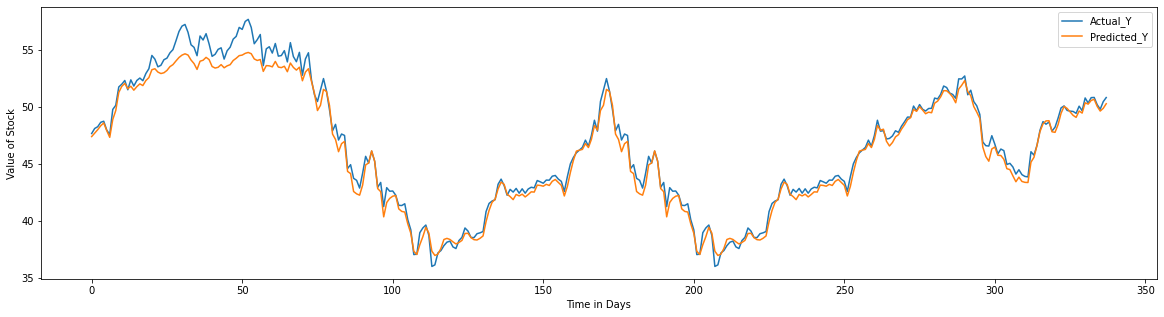

In [225]:
#Actual vs Predicted Graph
result_df.plot(figsize=(20,5))
mplot.xlabel('Time in Days')
mplot.ylabel('Value of Stock')

In [226]:
from pandas.tseries.offsets import BDay

#Prediction Forcastings
predictionCount = 9
lookback =155 
yesterday = end - timedelta(days=1)
trainingStartDate = (end - BDay(lookback)).to_pydatetime()
forcastingTrainingDays = yesterday - trainingStartDate
datelist_future = pd.date_range(end, periods=predictionCount, freq='C').tolist()  
datelist_training = pd.date_range(trainingStartDate, yesterday, freq='C').tolist()

y_past_training = model.predict(X_train[lookback-1:])
y_past_training_values = scaler.inverse_transform(y_past_training[0:lookback])
print('y_past_training_values with X_train: ')
print(y_past_training_values[-5:])

y_future_prediction = model.predict(X_train[-predictionCount:])
y_future_prediction_values = scaler.inverse_transform(y_future_prediction)
print('y_future_prediction_values with X_train: ')
print(y_future_prediction_values[:5])

#Look Back prediction
PREDICTIONS_FUTURE = pd.DataFrame(y_future_prediction_values, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_past_training_values, columns=['Open']).set_index(pd.Series(datelist_training)) 
PREDICTIONS_FUTURE.head(11)

y_past_training_values with X_train: 
[[46.785004]
 [46.43684 ]
 [47.15976 ]
 [48.37098 ]
 [47.96523 ]]
y_future_prediction_values with X_train: 
[[45.301083]
 [46.124302]
 [46.2085  ]
 [46.27365 ]
 [46.785004]]


ValueError: ignored

In [ ]:
mplot.figure(figsize=(20,10))
mplot.title(f"Opening Price Forcasting")
mplot.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
mplot.plot(PREDICTION_TRAIN.loc[trainingStartDate:].index, PREDICTION_TRAIN.loc[trainingStartDate:]['Open'], color='orange', label='Training predictions')
mplot.plot(stockDf.loc[trainingStartDate:].index, stockDf.loc[trainingStartDate:]['Open'], color='b', label='Actual Stock Price')
mplot.ylabel('Volume')
mplot.xlabel(None)
mplot.legend()
mplot.show() 